# pdstools version 3: Polars

With the version 3 release of pdstools, the back-end of the libary has shifted to use [Polars](https://github.com/pola-rs/polars). Polars is a blazingly fast DataFrames library implemented in Rust using Apache Arrow Columnar Format as the memory model. This means faster analyses and a more robust API: both externally and internally within our library. However, it is not a minor change, and will change the way you interact with the library. This article goes over some of the most notable changes, and most importantly: best practices.

First off:

## Lazy execution graphs

One of the, if not the single most powerful feature of Polars is its `lazy execution API`. This allows you to iteratively build up your query, have Polars optimise it for you, and only `collect` the data after your entire query. In practice, this means that all row-wise filters & column-wise selects are shifted right to whenever you read the file, and all computations are optimised further. Let's look at an example, and one close to home!

If we simply read in the shipped CDHSample dataset, and pass in the keyword `import_strategy='lazy'`, it will allow us to demonstrate this effect. Note: by default the import strategy is `'eager'`. We'll get to that later.

In [1]:
# These lines are only for rendering in the docs, and are hidden through Jupyter tags
# Do not run if you're running the notebook seperately

import plotly.io as pio

pio.renderers.default = "notebook_connected"

import sys

sys.path.append("../../../")
sys.path.append('../../python')

In [2]:
from pdstools import datasets, ADMDatamart
import polars as pl
dm = datasets.CDHSample(import_strategy='lazy')
dm

If you've used the previous version of pdstools, you've probably noticed nothing's changed. You still get the same `ADMDatamart` object. 

Try accessing the `modelData`, `predictorData` or `combinedData` property however, and things are different.

In [3]:
dm.modelData

<LazyFrame [15 cols, {"Performance": Float64 … "Last_ResponseCount": Datetime(time_unit='ns', time_zone=None)}] at 0x7F743856FE10>

Not a dataframe - but a `NAIVE QUERY PLAN`. It's relatively intuitive, but you'd read this chart bottom-to-top: 

- We read the table, $\pi$ `*/27;` (reading all columns out of the 27 available) and $\sigma$ `-;` (no row-wise filters applied).
- We then rename the columns by a predefined manner
- Then we only keep 12 out of the 27 available columns
- Change `["Issue","Group","Channel","Direction","Configuration"]` to be categorical, `"Performance"` to numeric.
- Transform `"SnapshotTime"` to datetime
- Add `["SuccessRate","Last_Positives","Last_ResponseCount"]` as columns.

A sharp eye might already notice an inefficiency here. If we first read in all columns, then rename and then filter, can't we already infer which columns we need based on our predefined function, and filter when reading? Well - yes!

This is the `naive` plan. If we call `.show_graph()`, we get the optimized version:

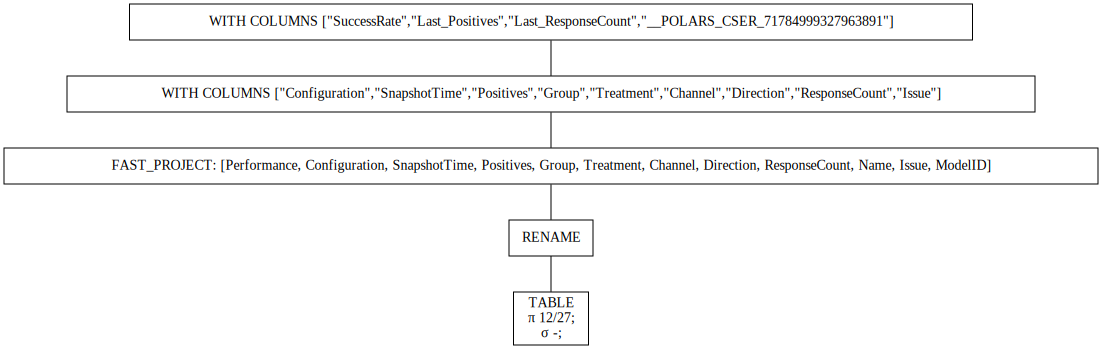

In [4]:
dm.modelData.show_graph()

At first glance; not a huge change. However, note at the bottom we import $\pi$ `12/27;`: we filter right when reading the file, and only read in 12 columns! This can make a big difference, especially because one column (`"pyModelData"`) is very big. 

Thus far, the $\sigma$ symbol has been `-`. We can also change that: the $\sigma$ symbol shows you which filters it applies on the rows when it's reading. For our example purpose, Let's say we're only interested in actions containing `Visa`. We can add that filter right to our execution plan!

To tell Polars we're trying to filter on a `column`, we simply start our query with `pl.col("Name")`. The `Name` column, containing the action names, is a string column. Therefore, to access `string`-based operations, we simply use `.str` to go to the `string namespace`. We want the string to `contain` `Visa`, therefore: `query=pl.col("Name").str.contains("Visa")`.

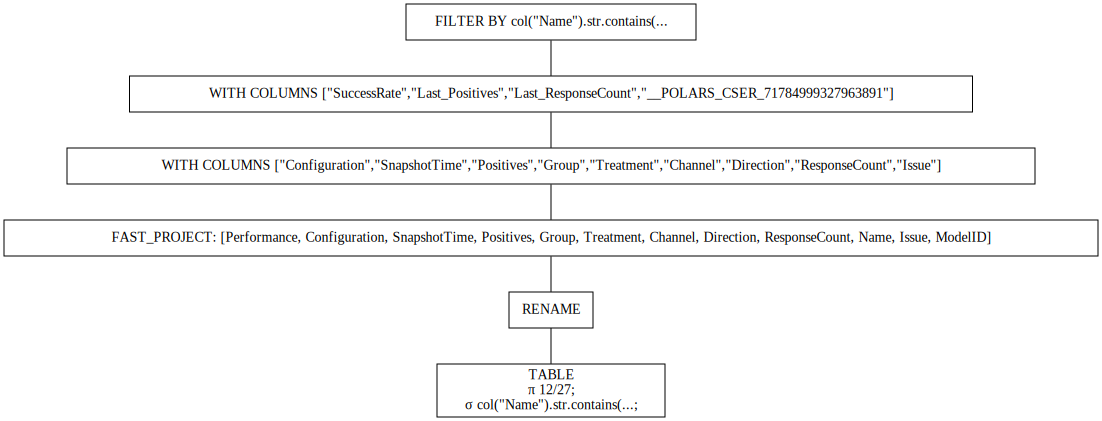

In [5]:
dm = datasets.CDHSample(
    import_strategy="lazy", query=pl.col("Name").str.contains("Visa")
)
dm.modelData.show_graph()

"Okay, but how do we actually get to the data?" - Simple! Just use `.collect()`.

In [6]:
dm.modelData.collect()

Performance,Configuration,SnapshotTime,Positives,Group,Treatment,Channel,Direction,ResponseCount,Name,Issue,ModelID,SuccessRate,Last_Positives,Last_ResponseCount
f64,cat,datetime[ns],f32,cat,str,cat,cat,f32,str,cat,str,f32,datetime[ns],datetime[ns]
0.5,"""OmniAdaptiveMo…",2021-06-01 08:23:26.789,1.0,"""CreditCards""",null,"""Web""","""Inbound""",72.0,"""VisaGold""","""Sales""","""17571d69-f802-…",0.013889,2021-06-01 13:23:26.789,2021-06-01 13:23:26.789
0.5,"""OmniAdaptiveMo…",2021-06-01 08:23:26.789,4.0,"""CreditCards""",null,"""SMS""","""Outbound""",166.0,"""VisaGold""","""Sales""","""1be7cd72-741b-…",0.024096,2021-06-01 13:23:26.789,2021-06-01 13:23:26.789
0.5,"""OmniAdaptiveMo…",2021-06-01 08:27:55.789,3.0,"""CreditCards""",null,"""Web""","""Inbound""",161.0,"""VisaGold""","""Sales""","""17571d69-f802-…",0.018634,2021-06-01 13:23:26.789,2021-06-01 13:23:26.789
0.5,"""OmniAdaptiveMo…",2021-06-01 09:03:01.789,3.0,"""CreditCards""",null,"""Web""","""Inbound""",161.0,"""VisaGold""","""Sales""","""17571d69-f802-…",0.018634,2021-06-01 13:23:26.789,2021-06-01 13:23:26.789
0.5,"""OmniAdaptiveMo…",2021-06-01 09:03:01.789,4.0,"""CreditCards""",null,"""SMS""","""Outbound""",166.0,"""VisaGold""","""Sales""","""1be7cd72-741b-…",0.024096,2021-06-01 13:23:26.789,2021-06-01 13:23:26.789
0.5,"""OmniAdaptiveMo…",2021-06-01 09:06:33.789,7.0,"""CreditCards""",null,"""SMS""","""Outbound""",271.0,"""VisaGold""","""Sales""","""1be7cd72-741b-…",0.02583,2021-06-01 13:23:26.789,2021-06-01 13:23:26.789
0.554538,"""OmniAdaptiveMo…",2021-06-01 09:06:33.789,12.0,"""CreditCards""",null,"""Web""","""Inbound""",233.0,"""VisaGold""","""Sales""","""17571d69-f802-…",0.051502,2021-06-01 13:23:26.789,2021-06-01 13:23:26.789
0.554538,"""OmniAdaptiveMo…",2021-06-01 09:34:34.789,12.0,"""CreditCards""",null,"""Web""","""Inbound""",233.0,"""VisaGold""","""Sales""","""17571d69-f802-…",0.051502,2021-06-01 13:23:26.789,2021-06-01 13:23:26.789
0.5,"""OmniAdaptiveMo…",2021-06-01 09:43:16.789,8.0,"""CreditCards""",null,"""SMS""","""Outbound""",353.0,"""VisaGold""","""Sales""","""1be7cd72-741b-…",0.022663,2021-06-01 13:23:26.789,2021-06-01 13:23:26.789


This table is very similar to Pandas tables, though there are some slight differences. The types are explicitly mentioned in the header, string values are in quotes, and long string values get cut off more agressively. Other than that, there's no real change! And if you still want to use pandas, just call `.to_pandas()` :)

In [7]:
dm.modelData.collect().to_pandas()

,Performance,Configuration,SnapshotTime,Positives,Group,Treatment,Channel,Direction,ResponseCount,Name,Issue,ModelID,SuccessRate,Last_Positives,Last_ResponseCount
0,0.500000,OmniAdaptiveModel,2021-06-01 08:23:26.789,1.0,CreditCards,None,Web,Inbound,72.0,VisaGold,Sales,17571d69-f802-5122-9bfe-6f3f4ef9073b,0.013889,2021-06-01 13:23:26.789,2021-06-01 13:23:26.789
1,0.500000,OmniAdaptiveModel,2021-06-01 08:23:26.789,4.0,CreditCards,None,SMS,Outbound,166.0,VisaGold,Sales,1be7cd72-741b-5d68-b148-c1af0142fd4a,0.024096,2021-06-01 13:23:26.789,2021-06-01 13:23:26.789
2,0.500000,OmniAdaptiveModel,2021-06-01 08:27:55.789,3.0,CreditCards,None,Web,Inbound,161.0,VisaGold,Sales,17571d69-f802-5122-9bfe-6f3f4ef9073b,0.018634,2021-06-01 13:23:26.789,2021-06-01 13:23:26.789
3,0.500000,OmniAdaptiveModel,2021-06-01 09:03:01.789,3.0,CreditCards,None,Web,Inbound,161.0,VisaGold,Sales,17571d69-f802-5122-9bfe-6f3f4ef9073b,0.018634,2021-06-01 13:23:26.789,2021-06-01 13:23:26.789
4,0.500000,OmniAdaptiveModel,2021-06-01 09:03:01.789,4.0,CreditCards,None,SMS,Outbound,166.0,VisaGold,Sales,1be7cd72-741b-5d68-b148-c1af0142fd4a,0.024096,2021-06-01 13:23:26.789,2021-06-01 13:23:26.789
5,0.500000,OmniAdaptiveModel,2021-06-01 09:06:33.789,7.0,CreditCards,None,SMS,Outbound,271.0,VisaGold,Sales,1be7cd72-741b-5d68-b148-c1af0142fd4a,0.025830,2021-06-01 13:23:26.789,2021-06-01 13:23:26.789
6,0.554538,OmniAdaptiveModel,2021-06-01 09:06:33.789,12.0,CreditCards,None,Web,Inbound,233.0,VisaGold,Sales,17571d69-f802-5122-9bfe-6f3f4ef9073b,0.051502,2021-06-01 13:23:26.789,2021-06-01 13:23:26.789
7,0.554538,OmniAdaptiveModel,2021-06-01 09:34:34.789,12.0,CreditCards,None,Web,Inbound,233.0,VisaGold,Sales,17571d69-f802-5122-9bfe-6f3f4ef9073b,0.051502,2021-06-01 13:23:26.789,2021-06-01 13:23:26.789
8,0.500000,OmniAdaptiveModel,2021-06-01 09:43:16.789,8.0,CreditCards,None,SMS,Outbound,353.0,VisaGold,Sales,1be7cd72-741b-5d68-b148-c1af0142fd4a,0.022663,2021-06-01 13:23:26.789,2021-06-01 13:23:26.789
9,0.541487,OmniAdaptiveModel,2021-06-01 09:43:16.789,19.0,CreditCards,None,Web,Inbound,320.0,VisaGold,Sales,17571d69-f802-5122-9bfe-6f3f4ef9073b,0.059375,2021-06-01 13:23:26.789,2021-06-01 13:23:26.789


Now, we don't just have modelData, there's also information about predictors. This is under the `predictorData` attribute, and it works the same way. Thirdly, we add a attribute called `combinedData`. `combinedData` is technically just an inner join between the model data and the predictor data on the model ID. Therefore, the model ID's we filter out of the models also propagate to the combined data. To give more insight into this join, we can now simply show the execution graph of it:

In [8]:
dm.combinedData

<LazyFrame [32 cols, {"Performance": Float64 … "PredictorCategory": Utf8}] at 0x7F742694FB10>

While a beautiful graph, it is quite a lot to digest. The left side of the chart should look very familiar, as should the right side. The 'middle' part is new: this is the execution part for the predictor data. Here we only parse `Performance` to be a float, parse the timezones, and add ["BinPropensity","BinAdjustedPropensity"]. For both the model data and the predictor data we take the last snapshot only when combining them, which you can see right before the topmost inner join.

Again, a sharp eye will notice quite some inefficiencies here. The newest issue is that we're now importing `modelData` twice, once to filter out model IDs not being in the filter criteria, and another time to join with the table. But remember, we're not in the optimized graph:

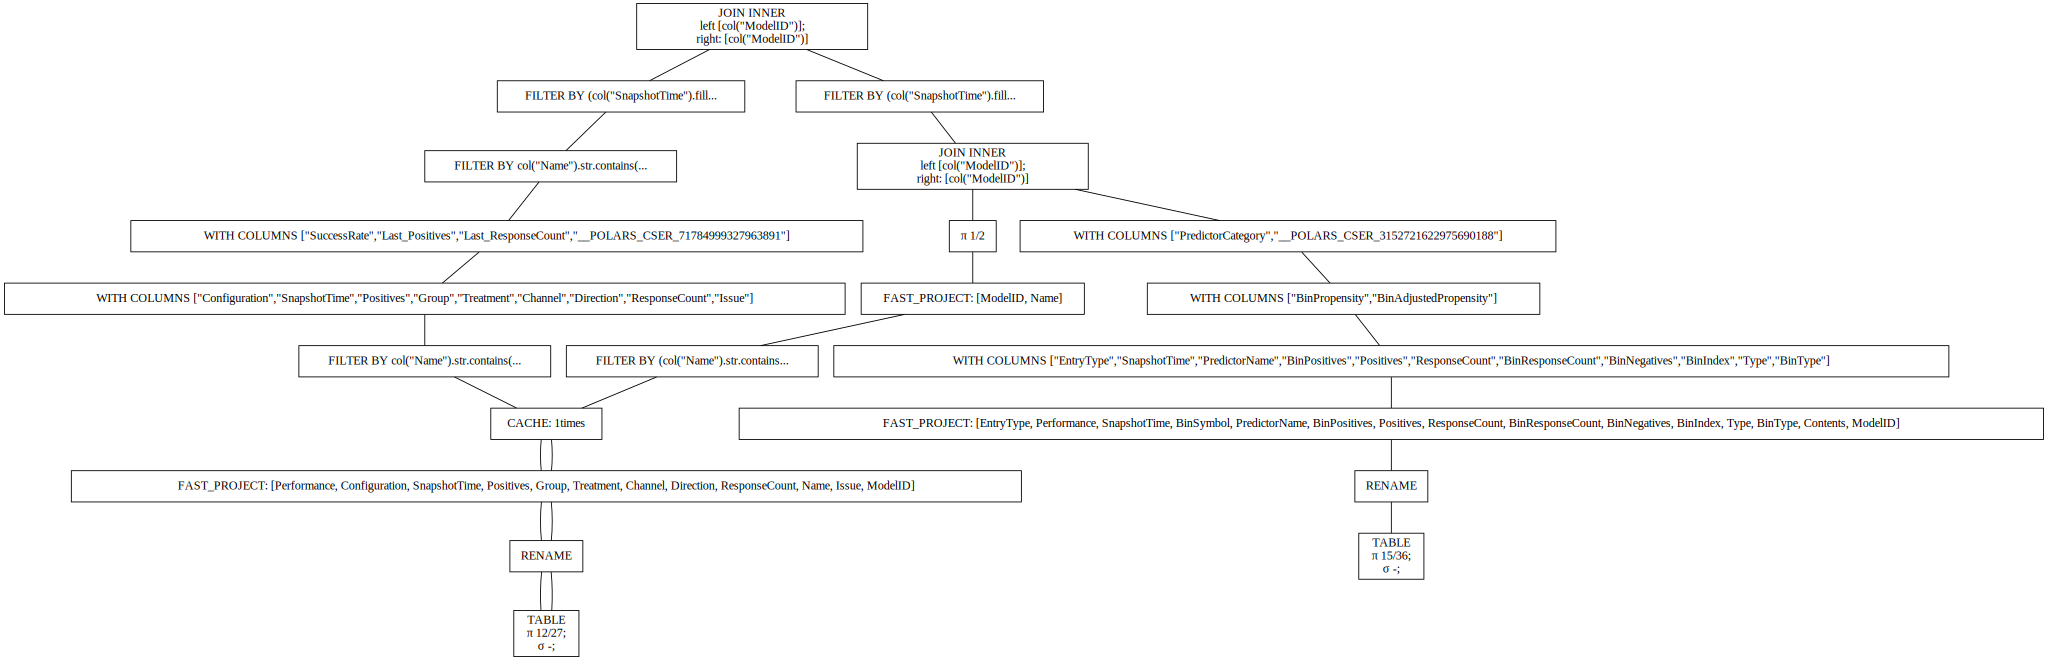

In [9]:
dm.combinedData.show_graph()

Pretty neat. Not only do we not import modelData twice, we cache it at a certain point in the execution graph so we can _use_ it twice. And we get all of this for free with Polars' optimization engine! Also remember, at this point, we've not even read in any data yet! We can even do profiling on this execution graph, but that's a challenge to figure out on your own :). We can easily show the gains in time using this method using our new `save_data` method though: this will save our data to disk in an efficient format, and gives us a fast way to benchmark.

In [10]:
files_without_subset = datasets.CDHSample(
    import_strategy="lazy", subset=False
).save_data()
files_with_subset = datasets.CDHSample(
    import_strategy="lazy", query=pl.col("Name").str.contains("Visa")
).save_data()


In [11]:
%timeit ADMDatamart(model_filename=files_without_subset[0], predictor_filename=files_without_subset[1], import_strategy='lazy').combinedData.collect()

14.7 ms ± 108 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
%timeit ADMDatamart(model_filename=files_with_subset[0], predictor_filename=files_with_subset[1], import_strategy='lazy').combinedData.collect()

9.69 ms ± 12.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
from os import remove
[remove(file) for file in [*files_with_subset, *files_without_subset]]

[None, None, None, None]

This +- 2x increase in speed will be even more significant as we increase the size of the data. 

## Lazy vs Eager
As mentioned before, however, the default mode of reading is `"eager"`. This still allows us to use the previously mentioned execution graph, but the difference is in what we do after we do all of this preprocessing, right before returning the ADMDatamart class: `.collect().lazy()`. Opening up `modelData` in `eager` mode shows that we don't have a graph anymore:

<class 'polars.lazyframe.frame.LazyFrame'>


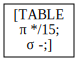

In [14]:
modd = datasets.CDHSample().modelData
print(type(modd))
modd.show_graph()


The type of `modelData` is a `LazyFrame` (the representation of this being a query plan). `DataFrame` and `LazyFrame`s are not so different - `LazyFrame`s build up a query and want you to execute once it's done, `DataFrame`s execute each command as you're calling it. However, in `eager` mode, that execution graph is empty.

That leads to the fundamental difference between the `import_strategy` keyword argument:
- In `lazy` mode - we only build the execution graph, but we rather than _reading_ the data, we only _scan_ it
- In `eager` mode - we build the execution graph and execute it, _reading_ all data into memory. This means we don't have to execute that graph everytime we call it.

The `eager` mode stil maintains `LazyFrame`s for both `modelData` and `predictorData`, but those tables are now not stored on disk anymore, but kept in memory. Any subsequent operations will build up a new execution graph, only executed when calling `.collect()`.

### When to use which?
By default, we use `eager` mode. We recommend using that, unless:

- Your data is too big to fit into memory
- You're using just one plot

In all other cases, it's probably fine to just use eager mode, _unless_.

## File Types

Pega's default export format is to return a zip file, in which is a `data.json` file, which is in newline-delimited json format. While this is a decent storage format, it doesn't allow for any scanning operations because we need to open the entire zip into memory before being able to read anything. Therefore, if you're using the default export format, we set the import strategy to eager. If you're working with very large files and you need faster processing, it may be worth it to unzip the files, or even transform them to Arrow/IPC (fastest) or Parquet (most efficient). Then, you can use lazy mode, and can process files larger than memory as an added benefit.


## Further Polars examples

To help you get adjusted to this new syntax, let's go over a few more examples.

The regular facets syntax still works, and can be combined with the new querying syntax.

In [15]:
dm = datasets.CDHSample()

dm.plotPerformanceSuccessRateBubbleChart(
    query=pl.col("Issue") == "Sales", facets=["Channel"]
)


However, if you want to _combine_ queries, let's say just looking at Sales/Web, the best way to do that is like this (also note the extra brackets between expressions):

In [16]:
dm.plotPerformanceSuccessRateBubbleChart(
    query=(pl.col("Issue") == "Sales") & (pl.col("Channel") == "Web")
)


We can make use of string operations (hover to verify for yourself!):

In [17]:
dm.plotPerformanceSuccessRateBubbleChart(
    query=(pl.col("Name").str.starts_with("Premier"))
    | (pl.col("Name").str.ends_with("Gold"))
)


Since we have full access to Polar's expressions, we can use a [very wide range of functions](https://pola-rs.github.io/polars/py-polars/html/reference/expressions/index.html), including windowing, folds, and slices. 

For something more advanced: let's look at the highest performance model per group.

In [18]:
dm.plotPerformanceSuccessRateBubbleChart(
    query=(pl.col("Performance") == pl.max("Performance")).over("Group")
)


Or we can look at temporal filters, like only looking at the first snapshot:

In [19]:
dm.plotPerformanceSuccessRateBubbleChart(query=pl.col('SnapshotTime')==pl.col('SnapshotTime').min())